# Medical Text Data Exploration

**Author:**
- Carlos Salgado - [email](mailto:csalgado@uwo.ca) | [GitHub](https://github.com/socd06) | [LinkedIn](www.linkedin.com/in/eng-socd)

## Problem Statement
Bob <sup>MD</sup> and Alice <sup>MD</sup> are physicians running their respective medical practices and both have a database of private medical transcriptions. You own a Natural Language Processing (NLP) company and have been contacted by these physicians because both Bob <sup>MD</sup> and Alice <sup>MD</sup> have heard of the high quality of the Machine Learning as a Service (MLaaS) solutions you provide and want you to create a text classifier to help them automatically assign a medical specialty to each new patient text transcription.

## Limitations

Healthcare data is highly regulated and should be, for most intents and purposes, private. Therefore, if in a medical setting, the Machine Learning model being trained should not actually look at the data. 

Combining both Bob's and Alice's datasets, you should be able to create a bigger, better dataset that you could use to train your model with higher accuracy, only that you can't because it's all sensitive and private data, which is why you will need [PySyft](https://github.com/OpenMined/pysyft/) and [SyferText](https://github.com/OpenMined/SyferText/) to complete the job at hand.

## Data Exploration
We will take advantage of this simulated dataset, since it is not a real-life scenario, we can and will be able to do data exploration to determine the best way to tackle the problem. 

## Importing libraries

Verifying requirements and installing if missing. 

In [1]:
!pip install -r ../requirements.txt

In [10]:
# Useful imports
import numpy as np
from tqdm import tqdm
import csv

import matplotlib.pyplot as plt
import seaborn as sb
import os
from pprint import pprint

sb.set()

Importing dataset downloader helper function from the `scripts` folder

In [11]:
import sys
sys.path.append('../scripts')

from util import download_dataset

## Downloading the Dataset

<div>
    <p style='color:red;'> (IGNORE THIS STEP IF YOU CLONED THE REPO OR ALREADY DOWNLOADED THE DATASET) </p>
</div>

The dataset will be downloaded in a folder called `data` in the root directory. Three files will be downloaded using the `download_dataset` helper function:

- `mtsamples.csv`: This is the dataset file containing almost 5K sample medical transcriptions. It is a csv file composed of five columns: `description`,`medical_specialty`,`sample_name`,`transcription`, and `keywords`. The `transcription` column holds the sample text, and the `medical_specialty` contains the labels we will use to train the classifier. 

- `clinical-stopwords.txt`: Clinical stop words compiled by [Dr. Kavita Ganesan](https://github.com/kavgan) from the [clinical-concepts](https://github.com/kavgan/clinical-concepts) repository. 

- `vocab.txt`: Vocabulary text file generated using the Systematized Nomenclature of Medicine International (SNMI) data.

- `mt.csv`: Reduced dataset containing only the `medical_specialty` and `transcription` features.

Please run the cell below in order to download the dataset. 

In [12]:
# The URL template to all dataset files
url_template = 'https://raw.githubusercontent.com/socd06/medical-nlp/master/data/%s'

# File names to be downloaded from the using the URL template above
files = ['mtsamples.csv', 'clinical-stopwords.txt', 'vocab.txt', 'mt.csv']

# Construct the list of urls
urls = [url_template % file for file in files]

# The dataset name and its root folder
dataset_name = 'data'
root_path = '../data'

# Create the dataset folder if it is not already there
if not os.path.exists('../data'):
    os.mkdir('../data')

# Start downloading
download_dataset(dataset_name = dataset_name, 
                 urls = urls, 
                 root_path = root_path
                )
print("Succesfully downloaded:",files)

Preparing to download dataset: `data` ...


data: 33.0MB [00:10, 3.27MB/s]                              

Succesfully downloaded: ['mtsamples.csv', 'clinical-stopwords.txt', 'vocab.txt', 'mt.csv']


## Data Exploration
Assuming you have access to the the anonymized combined data, you can do a very high-level data exploration in order to design the text classifier for the job. 

In [13]:
# Import tools for exploratory analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [14]:
# Reading dataset
df_full = pd.read_csv('../data/mtsamples.csv', delimiter=',')
df_full.dataframeName = 'mtsamples.csv'

In [15]:
# Taking a quick look at what the data looks like
df_full.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [16]:
# We should drop any records with empty transcription text, since its  the main source of text we will work with
#df = df['transcription'].dropna()

df = df_full.dropna(subset=['transcription'])

In [17]:
df

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."
...,...,...,...,...,...,...
4994,4994,Patient having severe sinusitis about two to ...,Allergy / Immunology,Chronic Sinusitis,"HISTORY:, I had the pleasure of meeting and e...",NaN
4995,4995,This is a 14-month-old baby boy Caucasian who...,Allergy / Immunology,Kawasaki Disease - Discharge Summary,"ADMITTING DIAGNOSIS: , Kawasaki disease.,DISCH...","allergy / immunology, mucous membranes, conjun..."
4996,4996,A female for a complete physical and follow u...,Allergy / Immunology,Followup on Asthma,"SUBJECTIVE: , This is a 42-year-old white fema...",NaN
4997,4997,Mother states he has been wheezing and coughing.,Allergy / Immunology,Asthma in a 5-year-old,"CHIEF COMPLAINT: , This 5-year-old male presen...",NaN


Now we can start our exploration

In [18]:
# Examine what the specialties are
df['medical_specialty'].unique()

array([' Allergy / Immunology', ' Bariatrics',
       ' Cardiovascular / Pulmonary', ' Neurology', ' Dentistry',
       ' Urology', ' General Medicine', ' Surgery', ' Speech - Language',
       ' SOAP / Chart / Progress Notes', ' Sleep Medicine',
       ' Rheumatology', ' Radiology', ' Psychiatry / Psychology',
       ' Podiatry', ' Physical Medicine - Rehab',
       ' Pediatrics - Neonatal', ' Pain Management', ' Orthopedic',
       ' Ophthalmology', ' Office Notes', ' Obstetrics / Gynecology',
       ' Neurosurgery', ' Nephrology', ' Letters',
       ' Lab Medicine - Pathology', ' IME-QME-Work Comp etc.',
       ' Hospice - Palliative Care', ' Hematology - Oncology',
       ' Gastroenterology', ' ENT - Otolaryngology', ' Endocrinology',
       ' Emergency Room Reports', ' Discharge Summary',
       ' Diets and Nutritions', ' Dermatology',
       ' Cosmetic / Plastic Surgery', ' Consult - History and Phy.',
       ' Chiropractic', ' Autopsy'], dtype=object)

In [19]:
# And how many different ones
len(df['medical_specialty'].unique())

40

In [20]:
df['medical_specialty'].value_counts()

 Surgery                          1088
 Consult - History and Phy.        516
 Cardiovascular / Pulmonary        371
 Orthopedic                        355
 Radiology                         273
 General Medicine                  259
 Gastroenterology                  224
 Neurology                         223
 SOAP / Chart / Progress Notes     166
 Urology                           156
 Obstetrics / Gynecology           155
 Discharge Summary                 108
 ENT - Otolaryngology               96
 Neurosurgery                       94
 Hematology - Oncology              90
 Ophthalmology                      83
 Nephrology                         81
 Emergency Room Reports             75
 Pediatrics - Neonatal              70
 Pain Management                    61
 Psychiatry / Psychology            53
 Office Notes                       50
 Podiatry                           47
 Dermatology                        29
 Cosmetic / Plastic Surgery         27
 Dentistry               

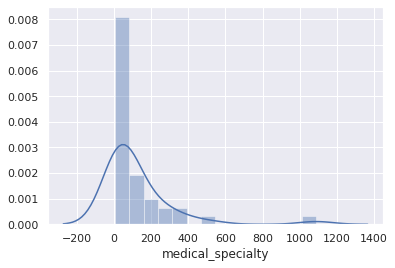

In [42]:
sb.distplot(df['medical_specialty'].value_counts());

In [28]:
df['medical_specialty'].value_counts().skew()

3.484787862528456

In [29]:
df['medical_specialty'].value_counts().kurt()

15.057632280038689

We have positive skewness and kurtosis 

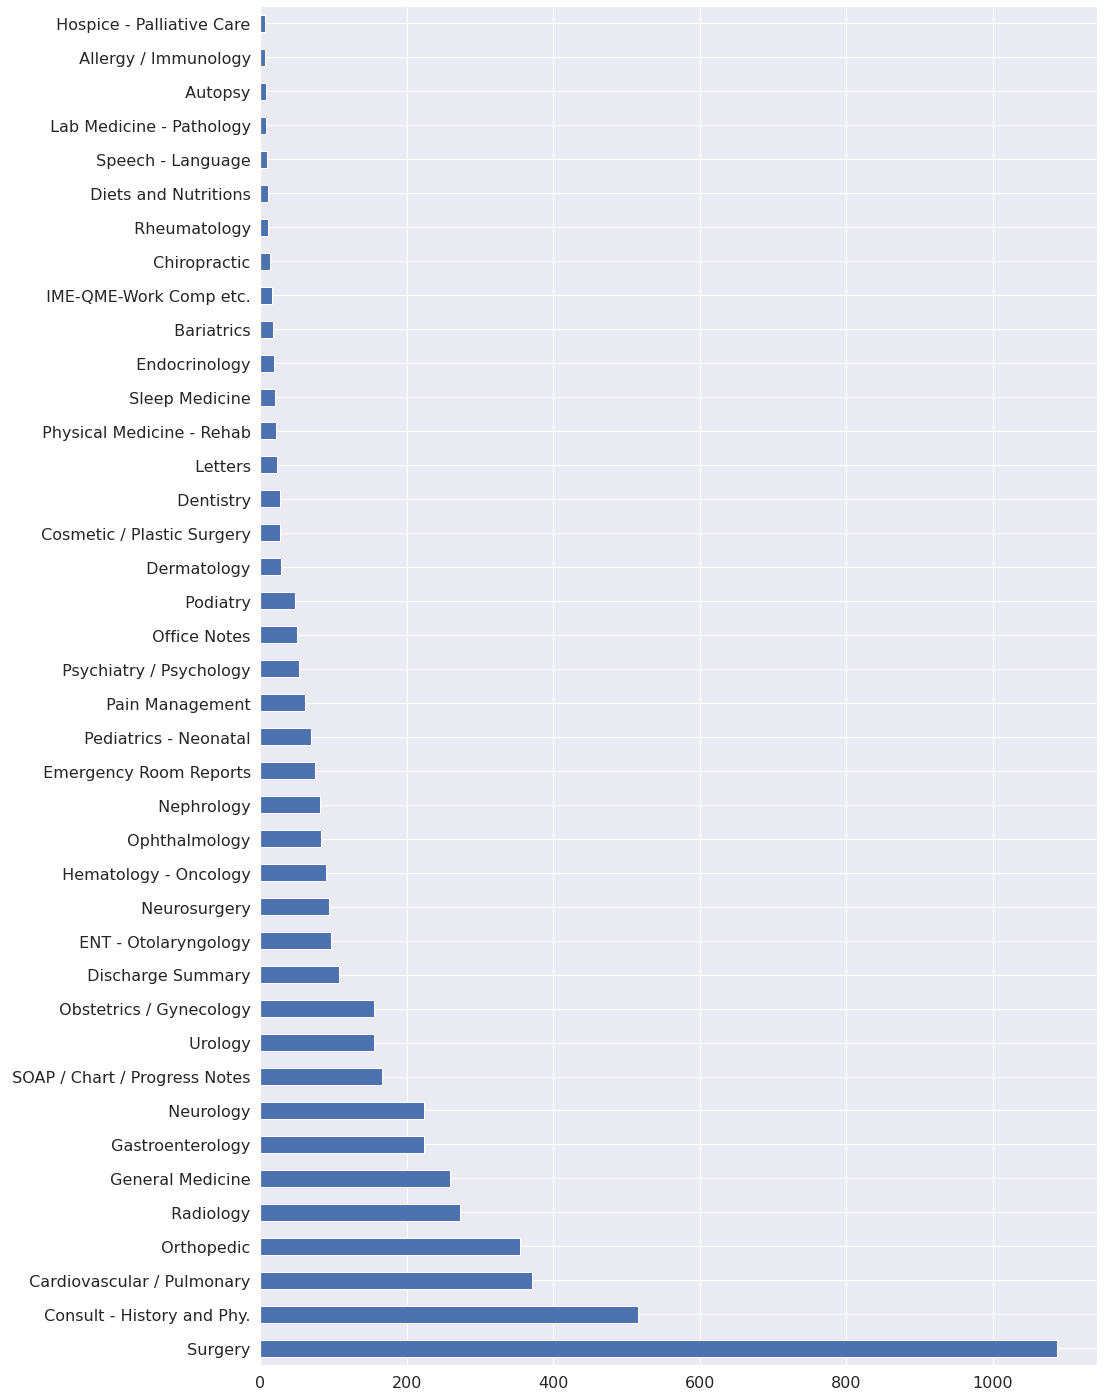

In [40]:
df['medical_specialty'].value_counts()[:40].plot(kind='barh', figsize=(15,25), fontsize=16)


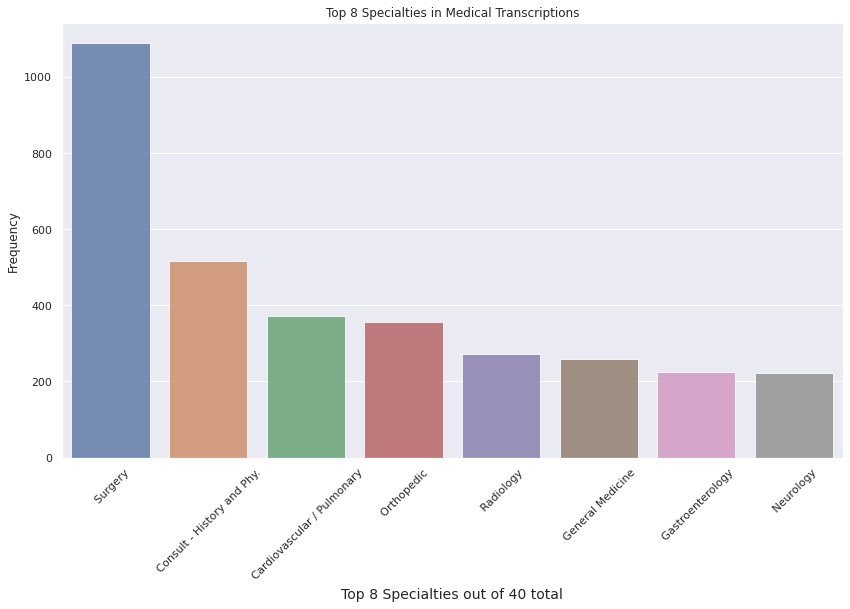

In [21]:
# Display the top 10 specialties most frequently repeated in the text
# The top 10 specialties will be most likely to be predicted since the model will be trained mainly on them
fig, ax = plt.subplots(figsize = (14,8)) # set size of figure
specialty = df['medical_specialty'].value_counts()
specialty = specialty[:8,]
g = sb.barplot(specialty.index, specialty.values, alpha=0.8)

plt.title("Top 8 Specialties in Medical Transcriptions")
plt.ylabel("Frequency", fontsize=12)
plt.xlabel("Top 8 Specialties out of 40 total", fontsize=14)

g.set_xticklabels(g.get_xticklabels(), rotation=45)

plt.show()

Because the data distribution is highly skewed towards the `surgery` specialty, we will focus our classifier on making the distinction of whether the `transcription` text is of the `surgery` specialty or not. A multi-class classifier could be trained using the first 8 specialties (ignoring the other 32 labels) with the most frequencies but making our model a binary classifier will yield much more consistent results.

In [22]:
# Choosing features
features = ['medical_specialty', 'transcription']

# Data is called X by convention
X = df[features]

In [23]:
# Confirming our new dataset only has the two columns chosen
X.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


Saving the new dataframe into a Comma Separated Values (*.csv) file

In [34]:
X.to_csv('../data/mt.csv', index = False)